In [1]:
!pip install tensorflow==2.2

     |████████████████████████████████| 516.2 MB 4.2 kB/s 
     |████████████████████████████████| 454 kB 48.0 MB/s 
     |████████████████████████████████| 2.9 MB 30.2 MB/s 
     |████████████████████████████████| 3.0 MB 29.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalli

In [2]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version:  2.2.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loader

Number of normal images found:  5000
Number of augmented images found:  14968
Number of totall images found:  19968
Shape of image:  (128, 512, 3)
Shape of image:  (128, 512, 3)
Shape of image:  (128, 512, 3)
Shape of image:  (128, 512, 3)


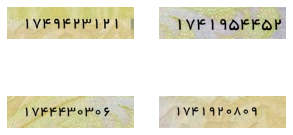

In [4]:
# Path to the data directory
data_dir_normal = Path("/content/drive/MyDrive/Dataset/NationalCode/normal")
data_dir_aug = Path("/content/drive/MyDrive/Dataset/NationalCode/augmented")

images_normal = list(data_dir_normal.glob("*.png"))
print("Number of normal images found: ", len(images_normal))

images_aug = list(data_dir_aug.glob("*.png"))
print("Number of augmented images found: ", len(images_aug))

# Get list of all the images
images = images_normal + images_aug
print("Number of totall images found: ", len(images))


# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [5]:
# Store all the characters in a set
characters = set()

# A list to store the length of each national code
code_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    code_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any national code: ", max(Counter(code_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  10
Maximum length of any national code:  10
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total number of samples in the dataset:  19968


,img_path,label
0,/content/drive/MyDrive/Dataset/NationalCode/au...,6856410891
1,/content/drive/MyDrive/Dataset/NationalCode/no...,0527704490
2,/content/drive/MyDrive/Dataset/NationalCode/au...,5959360861
3,/content/drive/MyDrive/Dataset/NationalCode/au...,4690256837
4,/content/drive/MyDrive/Dataset/NationalCode/au...,6256033914


In [6]:
# Split the dataset into training and test sets
training_data, test_data = train_test_split(dataset, test_size=0.2, random_state=seed)

training_data = training_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of test samples: ", len(test_data))



# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}



# Sanity check for corrupted images
def is_valid_code(code):
    for ch in code:
        if not ch in characters:
            return False
    return True
    
# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=128, img_width=512):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid code
        if is_valid_code(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)



# Build training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)


# Build test data
test_data, test_labels = generate_arrays(df=test_data)
print("Number of test images: ", test_data.shape)
print("Number of test labels: ", test_labels.shape)

Number of training samples:  15974
Number of test samples:  3994
Number of training images:  (15974, 128, 512)
Number of training labels:  (15974,)
Number of test images:  (3994, 128, 512)
Number of test labels:  (3994,)


In [7]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or test data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any code
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=512,
                 img_height=128,
                 downsample_factor=4,
                 max_length=10,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
          # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the code is valid
            if is_valid_code(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [8]:
# Batch size for training and test
batch_size = 16

# Desired image dimensions
img_width=512
img_height=128 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any code in the data
max_length=10

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the test data 
test_data_generator = DataGenerator(data=test_data,
                                     labels=test_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )
print("Number of train_data_generator: ", len(train_data_generator))
print("Number of test_data_generator: ", len(test_data_generator))

Number of train_data_generator:  999
Number of test_data_generator:  250


## Model

In [9]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss

In [10]:
# SimpleHTR model:
#kernel_vals = [5, 5, 3, 3, 3]
#feature_vals = [1, 32, 64, 128, 128, 256]
#stride_vals = pool_vals = [(2, 2), (2, 2), (1, 2), (1, 2), (1, 2)]

def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

    #inputs = keras.layers.Input(shape = (img_width, img_height, 1),name="image")
    conv1 = keras.layers.Conv2D(32, (5,5), activation = 'relu',padding='SAME', name='Conv1')(input_img)
    max1 = keras.layers.MaxPooling2D(pool_size=(2,2), name="pool1")(conv1)
    conv2 = keras.layers.Conv2D(64, (5,5), activation = 'relu', padding='SAME', name='Conv2')(max1)
    max2 =  keras.layers.MaxPooling2D(pool_size=(2,2), name="pool2")(conv2)
    conv3 =  keras.layers.Conv2D(128, (3,3), activation = 'relu',padding='SAME', name='Conv3')(max2)
    max3 =  keras.layers.MaxPooling2D(pool_size=(1,2), name="pool3")(conv3)
    #conv4 = keras.layers.Conv2D(128, (3,3), activation = 'relu',padding='SAME', name='Conv4')(max3)
    #max4 = keras.layers.MaxPooling2D(pool_size=(1,2), name="pool4")(conv4)
    #conv5 = keras.layers.Conv2D(256, (3,3), activation = 'relu',padding='SAME', name='Conv5')(max4)
    #max5 = keras.layers.MaxPooling2D(pool_size=(1,2), name="pool5")(conv5)

    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 512. Reshape accordingly before
    # passing it to RNNs
    
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(max3)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1, activation='softmax', name='dense2')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model
 

In [11]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 512, 128, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 512, 128, 32) 832         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 256, 64, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 256, 64, 64)  51264       pool1[0][0]                      
_______________________________________________________________________________________

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.1):
      self.model.stop_training= True


In [17]:
# Create a callback that saves the model's weights every 50 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Checkpoints/cp-20-new.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_freq=100)

In [ ]:
# Add early stopping
#es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
es = myCallback()
# Train the model
history = model.fit(train_data_generator,
                    epochs=500,
                    callbacks=[es,cp_callback])

Epoch 1/500
100/999 [==>...........................] - ETA: 1:07:48 - loss: 32.8092
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
200/999 [=====>........................] - ETA: 59:09 - loss: 28.9534
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
300/999 [========>.....................] - ETA: 51:47 - loss: 27.6469
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
400/999 [===========>..................] - ETA: 44:10 - loss: 26.9813
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
500/999 [==============>...............] - ETA: 36:52 - loss: 26.5812
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
600/999 [=================>............] - ETA: 29:34 - loss: 26.3102
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
700/999 [====================>.........] - ETA: 22:16 - loss: 26.0553
Epoch 00001: saving mo

In [ ]:
model.save("/content/drive/MyDrive/Models/train-keras-ours-new.h5", overwrite=True)

## To resume the training where we left off

In [15]:
# Create a basic model instance
model_ckpt2 = build_model()

# Load the previously saved weights
model_ckpt2.load_weights("/content/drive/MyDrive/Checkpoints/cp-20-new.ckpt")


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7fb73e856f90> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb740cd1f10>).


In [18]:
es = myCallback()
model_ckpt2.fit(train_data_generator, 
          epochs=500,
          callbacks=[es,cp_callback])

Epoch 1/500
 99/999 [=>............................] - ETA: 1:25:06 - loss: 0.1149
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
199/999 [====>.........................] - ETA: 1:15:46 - loss: 0.1049
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
299/999 [=======>......................] - ETA: 1:06:23 - loss: 0.0905
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
399/999 [==========>...................] - ETA: 56:52 - loss: 0.0885
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
499/999 [=============>................] - ETA: 47:25 - loss: 0.0930
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
599/999 [================>.............] - ETA: 37:56 - loss: 0.0932
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-20-new.ckpt
699/999 [===================>..........] - ETA: 28:27 - loss: 0.0883
Epoch 00001: saving model

In [19]:
model_ckpt2.save("/content/drive/MyDrive/Models/train-keras-ours-new.h5", overwrite=True)

In [20]:
model= model_ckpt2

## Prediction

In [21]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 512, 128, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 512, 128, 32)      832       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 256, 64, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 256, 64, 64)       51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 128, 32, 64)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 128, 32, 128)      73856     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 128, 16, 128)      0     

In [22]:
prediction_model.save("/content/drive/MyDrive/Models/prediction-model-keras-ours-new.h5", overwrite=True)

In [ ]:
from tensorflow.keras.models import load_model

prediction_model = load_model("/content/drive/MyDrive/Models/prediction-model-keras-ours-new.h5")

In [23]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [24]:
#  Let's check results on some test samples
for p, (inp_value, _) in enumerate(test_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Ground truth: 0370487087 	 Predicted: 0370487087
Ground truth: 5863282053 	 Predicted: 5863282053
Ground truth: 1216837821 	 Predicted: 1216837821
Ground truth: 6384591243 	 Predicted: 6384591243
Ground truth: 4287095261 	 Predicted: 4287095261
Ground truth: 4270447133 	 Predicted: 4270447133
Ground truth: 3950854223 	 Predicted: 3950854223
Ground truth: 5273419662 	 Predicted: 5273419662
Ground truth: 6657008473 	 Predicted: 6657008473
Ground truth: 1559909511 	 Predicted: 1559909511
Ground truth: 1253339971 	 Predicted: 1253339971
Ground truth: 1157250483 	 Predicted: 1157250483
Ground truth: 0482505125 	 Predicted: 0482505125
Ground truth: 3668558132 	 Predicted: 3668558132
Ground truth: 2730935592 	 Predicted: 2730935592
Ground truth: 4482897353 	 Predicted: 4482897353


In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(orig_texts, pred_texts)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [26]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(orig_texts, pred_texts)

1.0

In [27]:
#  Let's check results on some test samples
pred_tests=[]
gt_tests=[]
for p, (inp_value, _) in enumerate(test_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    pred_tests= pred_tests + pred_texts

    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        gt_tests.append(orig_texts)
'''
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    print(len(pred_tests))     
    print(len(gt_tests))
'''    

"\n    for i in range(bs):\n        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')\n    print(len(pred_tests))     \n    print(len(gt_tests))\n"

In [28]:
print(len(pred_tests))

3994


In [29]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_tests)

0.9944917376064096

In [30]:
print(gt_tests)

[['0370487087', '5863282053', '1216837821', '6384591243', '4287095261', '4270447133', '3950854223', '5273419662', '6657008473', '1559909511', '1253339971', '1157250483', '0482505125', '3668558132', '2730935592', '4482897353'], ['0370487087', '5863282053', '1216837821', '6384591243', '4287095261', '4270447133', '3950854223', '5273419662', '6657008473', '1559909511', '1253339971', '1157250483', '0482505125', '3668558132', '2730935592', '4482897353'], ['0370487087', '5863282053', '1216837821', '6384591243', '4287095261', '4270447133', '3950854223', '5273419662', '6657008473', '1559909511', '1253339971', '1157250483', '0482505125', '3668558132', '2730935592', '4482897353'], ['0370487087', '5863282053', '1216837821', '6384591243', '4287095261', '4270447133', '3950854223', '5273419662', '6657008473', '1559909511', '1253339971', '1157250483', '0482505125', '3668558132', '2730935592', '4482897353'], ['0370487087', '5863282053', '1216837821', '6384591243', '4287095261', '4270447133', '395085422

In [31]:
print(test_labels)

['0370487087' '5863282053' '1216837821' ... '5079296186' '1145220088'
 '2734644231']


In [32]:
print(pred_tests)

['0370487087', '5863282053', '1216837821', '6384591243', '4287095261', '4270447133', '3950854223', '5273419662', '6657008473', '1559909511', '1253339971', '1157250483', '0482505125', '3668558132', '2730935592', '4482897353', '7037709468', '3696574351', '6715982120', '2235956491', '7199012071', '6374270691', '1216619158', '4587169587', '5138204416', '1464647046', '4530437884', '5095549834', '1929023790', '4607123307', '3055602595', '5912159231', '4870578778', '6894742431', '2597381099', '5554689892', '0060951532', '3590134429', '3967760162', '6576458738', '1062704282', '5086317185', '0735556040', '2024782973', '6337520122', '5837737758', '1361161116', '4894579707', '6019854140', '3305412240', '6277060988', '2084064864', '2618185390', '6866237009', '2596901013', '5192967899', '3854115830', '0388946709', '2142967681', '7001077453', '1966771681', '2189135478', '5129383461', '6763304498', '5928497547', '2401327991', '5665733040', '4935720743', '2435045662', '3195347571', '4653772193', '4188

#Conversion from Keras to ONNX

In [33]:
# let's install the onnx packages from the source

!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx

     |████████████████████████████████| 4.5 MB 5.4 MB/s 
     |████████████████████████████████| 12.3 MB 5.3 MB/s 
     |████████████████████████████████| 87 kB 3.4 MB/s 


In [34]:
# convert to onnx model
import keras2onnx
onnx_prediction_model = keras2onnx.convert_keras(prediction_model, 'keras-ours-prediction-onnx')
output_prediction_model_path = "./keras-ours-prediction-model-new.onnx"
# and save the model in ONNX format
keras2onnx.save_model(onnx_prediction_model, output_prediction_model_path)

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 44 -> 26
